In [4]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Load and format  data

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,3171,3631,4019,4369,4551,4969,4983,4713,5407,5428,...,990,982,1023,928,922,1033,1061,1026,1219,1204
1,3586,3582,4122,4248,5005,5038,5276,4802,5966,6371,...,1455,1428,1373,1457,1138,1224,1463,1406,1487,1433
2,4513,4072,4737,4888,5380,6139,6668,6156,7530,8122,...,1356,1037,1172,1283,1448,1526,1554,1694,1913,2228
3,5641,6444,6941,7434,7915,8687,9104,8570,9171,8436,...,2166,2289,2220,2368,2237,2429,2461,2788,3735,3400
4,5687,5959,5896,6485,6987,7297,7667,7733,7634,8708,...,5735,5587,5526,5877,8941,14556,21350,22561,26091,24454
5,48420,58196,69068,66411,57017,42729,32520,22508,21730,19325,...,3850,4077,4008,4518,4420,5007,5493,5510,6741,6387
6,8473,9347,9684,9904,11020,11807,13336,12079,13997,14958,...,3538,3202,3523,3874,4444,4717,4813,5567,5822,6708
7,9365,9803,9958,10298,11396,11496,11721,10377,11479,11187,...,5103,5159,5026,5051,6141,6318,6296,7382,7656,7807
8,9395,10158,10585,10913,11061,12674,13623,14650,18521,24877,...,4233,3886,4075,4168,4317,5053,5626,6374,7110,7963
9,9677,10420,10658,12036,12502,13498,13927,15168,13975,18920,...,4765,4942,4744,4980,5305,5799,6050,8130,8888,8874


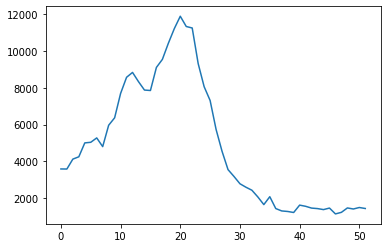

In [5]:
# Load Dataset
ilinet_full = pd.DataFrame(pd.read_csv('ILINet.csv'))
ilinet_full_seasons =ilinet_full[0:782]
data = ilinet_full_seasons['ILITOTAL'].values
#scaler = MinMaxScaler(feature_range=(-1, 1))
#data=scaler.fit_transform(ilinet_full_seasons['ILITOTAL'].values.reshape(-1, 1))

# format data to be seasonal
end_weeks=ilinet_full_seasons.index[ilinet_full_seasons['WEEK'] == 39].tolist()
start_weeks=ilinet_full_seasons.index[ilinet_full_seasons['WEEK'] == 40].tolist()

seasons=[]
for i in range(len(start_weeks)):
    c=start_weeks[i]
    seasons.append(data[c:c+52])
seasons=np.vstack(seasons)
plt.plot(seasons[1])
seasons_df = pd.DataFrame(seasons)
seasons_df

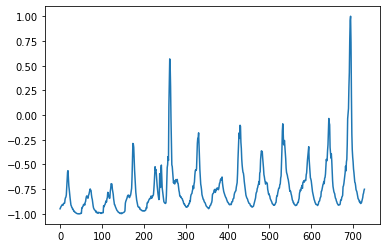

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
maxval = seasons.max()
minval = seasons.min()
scaleddata = scaler.fit_transform(seasons[0:-1].reshape(-1, 1))
train_data = torch.FloatTensor(scaleddata).view(-1)
plt.plot(train_data)

# Implement Seq2Seq 
Adapted from
https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


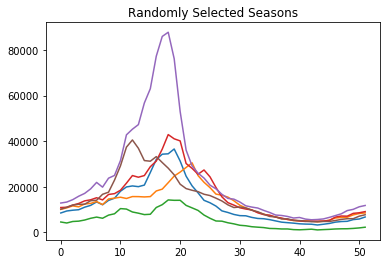

In [8]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=8)
    
    for i in range(len(sample)):
        plt.plot(sample.iloc[i])
    
    plt.title('Randomly Selected Seasons')
    
plot_random_series(seasons_df, 6)

In [9]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

latent_dim = 50 # LSTM hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [11]:
def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [12]:
#first_n_samples = 20000
batch_size = 2**11
epochs = 100

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = seasons[0:-1]#get_time_block_series(series_array, date_to_index, 
                                           #train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = seasons[-1]#get_time_block_series(series_array, date_to_index, 
                                            #train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 11 samples, validate on 3 samples
Epoch 1/100
11/11 [==============================] - 1s 78ms/step - loss: 0.8289 - val_loss: 0.4763
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7709 - val_loss: 0.4576
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7620 - val_loss: 0.4431
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 0.5933 - val_loss: 0.4307
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 0.5547 - val_loss: 0.4209
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 0.5860 - val_loss: 0.4129
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 0.6839 - val_loss: 0.4066
Epoch 8/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7038 - val_loss: 0.4008
Epoch 9/100
11/11 [==============================] - 0s 4ms/step - loss: 0.4790 - val_loss: 0.3944
Epoch 10/100
11/1

11/11 [==============================] - 0s 5ms/step - loss: 0.3160 - val_loss: 0.2069
Epoch 81/100
11/11 [==============================] - 0s 5ms/step - loss: 0.2601 - val_loss: 0.2093
Epoch 82/100
11/11 [==============================] - 0s 5ms/step - loss: 0.2327 - val_loss: 0.2105
Epoch 83/100
11/11 [==============================] - 0s 5ms/step - loss: 0.2295 - val_loss: 0.2108
Epoch 84/100
11/11 [==============================] - 0s 5ms/step - loss: 0.2789 - val_loss: 0.2102
Epoch 85/100
11/11 [==============================] - 0s 5ms/step - loss: 0.2889 - val_loss: 0.2111
Epoch 86/100
11/11 [==============================] - 0s 5ms/step - loss: 0.2527 - val_loss: 0.2119
Epoch 87/100
11/11 [==============================] - 0s 5ms/step - loss: 0.3771 - val_loss: 0.2150
Epoch 88/100
11/11 [==============================] - 0s 6ms/step - loss: 0.2661 - val_loss: 0.2182
Epoch 89/100
11/11 [==============================] - 0s 6ms/step - loss: 0.2640 - val_loss: 0.2198
Epoch 90/100


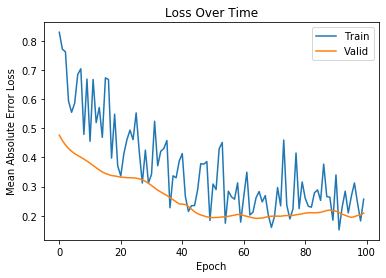

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [14]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [15]:
encoder_input_data = seasons[0:-1]#get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = seasons[-1]#get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [16]:
pred_steps=52
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

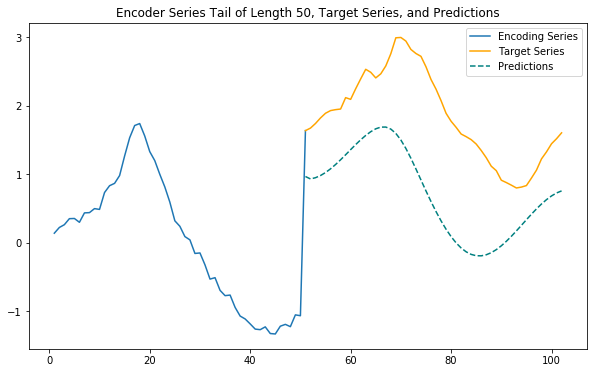

In [17]:
predict_and_plot(encoder_input_data, decoder_target_data, 0)